# Temporal Consistency Regularization Approach for Continual Learning

In this notebook, we explore a novel approach for our autonomous driving setting.

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import ntpath

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

## Data Pre-Processing

In [2]:
data_path = 'data'
path = os.path.join(data_path,'driving_log.csv')
data = pd.read_csv(path)

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [4]:
center = data[data.columns[0]].values
left = data[data.columns[1]].values
right = data[data.columns[2]].values
steering = data[data.columns[3]].values

no_of_examples = len(steering)
print("Total Number of Samples :", no_of_examples)

Total Number of Samples : 8036


In [5]:
image_path = 'IMG'
image_path = os.path.join(data_path, image_path)

In [6]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

In [7]:
x_train = []
prev_steering_angle_train = []
y_train = []

x_test = []
prev_steering_angle_test = []
y_test = []

steer_adjust_factor = 0.2
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 100
test_size = 1536

for flip in range(2):
    for i in range(no_of_examples):
        for choice in range(3):
            if choice == 0: # Center Image
                img = cv2.imread(os.path.join(image_path, center[i]))
                steering_angle = steering[i]
            elif choice == 1: # Left Image
                img = cv2.imread(os.path.join(image_path, left[i]))
                steering_angle = steering[i] + steer_adjust_factor
            elif choice == 2: # Right Image
                img = cv2.imread(os.path.join(image_path, right[i]))
                steering_angle = steering[i] - steer_adjust_factor
            
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
            img = img[50:,:]
            img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
            
            if flip:
                img, steering_angle = random_flip(img, steering_angle)
                    
            if i >= no_of_examples - test_size:
                # Add to test set
                x_test.append(img)
                y_test.append(steering_angle)
                prev_steering_angle_test.append(steering[i - 1] if i > 0 else 0.0)  # Assuming 0.0 if no previous data
            else:
                # Add to training set
                x_train.append(img)
                y_train.append(steering_angle)
                prev_steering_angle_train.append(steering[i - 1] if i > 0 else 0.0)  # Assuming 0.0 if no previous data

# Convert lists to numpy arrays
x_train = np.array(x_train)
prev_steering_angle_train = np.array(prev_steering_angle_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
prev_steering_angle_test = np.array(prev_steering_angle_test)
y_test = np.array(y_test)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
prev_steering_angle_train = np.reshape(prev_steering_angle_train, (len(prev_steering_angle_train), 1))
y_train = np.reshape(y_train, (len(y_train), 1))

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
prev_steering_angle_test = np.reshape(prev_steering_angle_test, (len(prev_steering_angle_test), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

print("x train shape :", x_train.shape)
print("y train shape :", y_train.shape)
print('')
print("x test shape :", x_test.shape)
print("y test shape :", y_test.shape)

x train shape : (39000, 100, 100, 1)
y train shape : (39000, 1)

x test shape : (9216, 100, 100, 1)
y test shape : (9216, 1)


In [8]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, label_tensor, prev_angles):
        self.data = data_tensor
        self.labels = label_tensor
        self.prev_angles = prev_angles

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.prev_angles[idx]

def custom_collate_fn(batch):
    # Transpose the batch list
    data, labels, prev_angles = zip(*batch)
    
    # Stack data and labels
    data = torch.stack(data, dim=0)
    labels = torch.stack(labels, dim=0)
    prev_angles = torch.stack(prev_angles, dim=0)
    
    return data, labels, prev_angles

In [9]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
    self.dataset = dl.dataset

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [10]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

We split the dataset into different driving contexts

In [11]:
# Driving Straight Context on Train Dataset
train_straight_idxs = ((y_train <= 0.2) & (y_train >= -0.2)).nonzero()[0].squeeze()

# Driving on Left Curves Context on Train Dataset
train_left_idxs = ((y_train < -0.2) & (y_train >= -0.5)).nonzero()[0].squeeze()

# Driving on Right Curves Context on Train Dataset
train_right_idxs = ((y_train > 0.2 )& (y_train <= 0.5)).nonzero()[0].squeeze()

# Driving on Left Turns Context on Train Dataset
train_sharp_left_idxs = (y_train < -0.5).nonzero()[0].squeeze()

# Driving on Right Turns Context on Train Dataset
train_sharp_right_idxs = (y_train > 0.5).nonzero()[0].squeeze()

In [12]:
# Driving Straight Context on Test Dataset
test_straight_idxs = ((y_test <= 0.2) & (y_test >= -0.2)).nonzero()[0].squeeze()

# Driving on Left Curves Context on Test Dataset
test_left_idxs = ((y_test < -0.2) & (y_test >= -0.5)).nonzero()[0].squeeze()

# Driving on Right Curves Context on Test Dataset
test_right_idxs = ((y_test > 0.2 )& (y_test <= 0.5)).nonzero()[0].squeeze()

# Driving on Left Turns Context on Test Dataset
test_sharp_left_idxs = (y_test < -0.5).nonzero()[0].squeeze()

# Driving on Right Turns Context on Test Dataset
test_sharp_right_idxs = (y_test > 0.5).nonzero()[0].squeeze()

In [13]:
train_contexts = [train_straight_idxs, train_left_idxs, train_right_idxs, train_sharp_left_idxs, train_sharp_right_idxs]
test_contexts = [test_straight_idxs, test_left_idxs, test_right_idxs, test_sharp_left_idxs, test_sharp_right_idxs]

## Model

In [14]:
class CNNModel(nn.Module):
    def __init__(self, height, width):
        super(CNNModel, self).__init__()
        
        self.height = height
        self.width = width
        
        # Input normalization
        self.norm = nn.BatchNorm2d(1)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (height // 16) * (width // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(65, 1)
        
        # Dropout and Batch normalization
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x, prev_angle):
        x = self.norm(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.batchnorm1(self.fc1(x))
        x = self.batchnorm2(self.fc2(x))
        x = self.batchnorm3(self.fc3(x))
        x = torch.cat((x, prev_angle), dim = 1)
        x = self.fc4(x)
        return x

In [31]:
model = CNNModel(IMAGE_HEIGHT, IMAGE_WIDTH)

In [32]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [33]:
print(summary(model, input_size=[(1, IMAGE_HEIGHT, IMAGE_WIDTH), (1,)]))

Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                            320
├─Conv2d: 1-3                            9,248
├─Conv2d: 1-4                            18,496
├─Conv2d: 1-5                            36,928
├─Conv2d: 1-6                            73,856
├─Conv2d: 1-7                            147,584
├─MaxPool2d: 1-8                         --
├─Linear: 1-9                            2,359,808
├─Linear: 1-10                           131,328
├─Linear: 1-11                           16,448
├─Linear: 1-12                           66
├─Dropout: 1-13                          --
├─BatchNorm1d: 1-14                      1,024
├─BatchNorm1d: 1-15                      512
├─BatchNorm1d: 1-16                      128
Total params: 2,795,748
Trainable params: 2,795,748
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                         

In [34]:
epochs = 10
lambda_tc = 0.01
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

## Model Training

In [35]:
# Training Helper Function to Format Time
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

In [36]:
# Number of past experiences to replay per context
replay_size_per_context = 100  # Adjust this value based on memory constraints

In [37]:
# Initialize replay buffer
replay_buffers = {context_idx: [] for context_idx in range(len(train_contexts))}

In [38]:
# Function to add experiences to replay buffer
def add_to_replay_buffer(context_idx, inputs, labels, prev_angles):
    replay_buffers[context_idx].extend(list(zip(inputs.cpu().numpy(), labels.cpu().numpy(), prev_angles.cpu().numpy())))
    if len(replay_buffers[context_idx]) > replay_size_per_context:
        replay_buffers[context_idx] = replay_buffers[context_idx][-replay_size_per_context:]

In [39]:
# Train the model for each context
train_losses_per_context = []

for context_idx, idxs in enumerate(train_contexts):
    print(f"Training for Context {context_idx + 1}")

    # Create a dataset and dataloader for the current context
    context_dataset = CustomDataset(torch.tensor(x_train[idxs], dtype=torch.float32).permute(0, 3, 1, 2).to(device),
                              torch.tensor(y_train[idxs], dtype=torch.float32),
                              torch.tensor(prev_steering_angle_train[idxs], dtype=torch.float32))
    
    context_loader = DataLoader(context_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)

    train_losses = []
    
    # Train the model
    for epoch in range(epochs):
        start_time = time.time()
        
        train_running_loss = 0.0

        model.train()
        
        for inputs, labels, prev_angles in context_loader:
            inputs, labels, prev_angles = inputs.to(device), labels.to(device), prev_angles.to(device)
            prev_angles = prev_angles.reshape((len(prev_angles),1))
            
            optimizer.zero_grad()
            
            # Experience Replay
            if len(replay_buffers[context_idx]) > 0:
                # Sample equally from all contexts
                replay_samples_per_context = replay_size_per_context // len(train_contexts)
                replay_samples = []
                
                for i in range(len(train_contexts)):
                    context_samples = replay_buffers[i]
                    selected_samples = random.sample(context_samples, min(len(context_samples), len(inputs)))
                    replay_samples.extend(selected_samples)

                replay_data = list(zip(*replay_samples))
                replay_inputs = torch.tensor(replay_data[0], device=device, dtype=torch.float32)
                replay_labels = torch.tensor(replay_data[1], device=device, dtype=torch.float32)
                replay_prev_angles = torch.tensor(replay_data[2], device=device, dtype=torch.float32)
    
                
                replay_inputs = torch.tensor(replay_inputs, device=device, dtype=torch.float32)
                replay_labels = torch.tensor(replay_labels, device=device, dtype=torch.float32)
                replay_prev_angles = torch.tensor(replay_data[2], device=device, dtype=torch.float32)
                
                inputs_final = torch.cat([inputs, replay_inputs], dim=0)
                labels_final = torch.cat([labels, replay_labels], dim=0)
                prev_angles_final = torch.cat([prev_angles, replay_prev_angles], dim=0)
            else:
                inputs_final = inputs.clone().detach()
                labels_final = labels.clone().detach()
                prev_angles_final = prev_angles.clone().detach()
            
            outputs = model(inputs_final, prev_angles_final)
            loss = criterion(outputs, labels_final)

            tc_loss = lambda_tc * criterion(outputs[:, 0], prev_angles_final[:, 0])

            loss += tc_loss
            
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item() * inputs_final.size(0)

            # Add current batch to replay buffer
            add_to_replay_buffer(context_idx, inputs, labels, prev_angles)
        
        train_epoch_loss = train_running_loss / len(context_loader.dataset)
        train_losses.append(train_epoch_loss)

        cur_time = time.time()
        epoch_time = cur_time - start_time
        
        print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_epoch_loss:.4f}')
        print(f'Time Taken : {format_time(epoch_time)}')
        print('')
    
    train_losses_per_context.append(train_losses)
    
    print('---')
    print('')

Training for Context 1
Epoch [1/10] | Train Loss: 0.0345
Time Taken : 57s874ms

Epoch [2/10] | Train Loss: 0.0105
Time Taken : 58s65ms

Epoch [3/10] | Train Loss: 0.0097
Time Taken : 58s91ms

Epoch [4/10] | Train Loss: 0.0090
Time Taken : 58s103ms

Epoch [5/10] | Train Loss: 0.0090
Time Taken : 58s116ms

Epoch [6/10] | Train Loss: 0.0087
Time Taken : 58s151ms

Epoch [7/10] | Train Loss: 0.0085
Time Taken : 58s157ms

Epoch [8/10] | Train Loss: 0.0083
Time Taken : 58s172ms

Epoch [9/10] | Train Loss: 0.0081
Time Taken : 58s186ms

Epoch [10/10] | Train Loss: 0.0080
Time Taken : 58s169ms

---

Training for Context 2
Epoch [1/10] | Train Loss: 0.0451
Time Taken : 11s423ms

Epoch [2/10] | Train Loss: 0.0194
Time Taken : 11s642ms

Epoch [3/10] | Train Loss: 0.0165
Time Taken : 11s675ms

Epoch [4/10] | Train Loss: 0.0145
Time Taken : 11s666ms

Epoch [5/10] | Train Loss: 0.0122
Time Taken : 11s655ms

Epoch [6/10] | Train Loss: 0.0116
Time Taken : 11s650ms

Epoch [7/10] | Train Loss: 0.0113
Time

## Model Evaluation

In [40]:
# Evaluate the final trained model on the test subsets for each context
test_losses_per_context = []

for context_idx, idxs_test in enumerate(test_contexts):
    print(f"Evaluating on Test Dataset for Context {context_idx + 1}")
    
    test_context_dataset = CustomDataset(torch.tensor(x_test[idxs_test], dtype=torch.float32).permute(0, 3, 1, 2).to(device),
                              torch.tensor(y_test[idxs_test], dtype=torch.float32),
                              torch.tensor(prev_steering_angle_test[idxs_test], dtype=torch.float32))
    
    context_test_loader = DataLoader(test_context_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
    
    model.eval()
    
    test_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels, prev_angle in context_test_loader:
            inputs, labels, prev_angle = inputs.to(device), labels.to(device), prev_angle.to(device)
            outputs = model(inputs, prev_angle)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
    
    test_context_loss = test_running_loss / len(context_test_loader.dataset)
    test_losses_per_context.append(test_context_loss)
    
    print(f"Test Loss for Context {context_idx + 1} : {test_context_loss:.4f}")
    print('')

Evaluating on Test Dataset for Context 1
Test Loss for Context 1 : 0.0332

Evaluating on Test Dataset for Context 2
Test Loss for Context 2 : 0.0296

Evaluating on Test Dataset for Context 3
Test Loss for Context 3 : 0.0281

Evaluating on Test Dataset for Context 4
Test Loss for Context 4 : 0.0474

Evaluating on Test Dataset for Context 5
Test Loss for Context 5 : 0.0328



In [41]:
# Calculating Overall Test Loss
overall_test_loss = sum(test_losses_per_context) / len(test_losses_per_context)
print(f"Overall Test Loss: {overall_test_loss:.4f}")

Overall Test Loss: 0.0342


Text(0.5, 1.0, 'Loss vs. No. of Iterations')

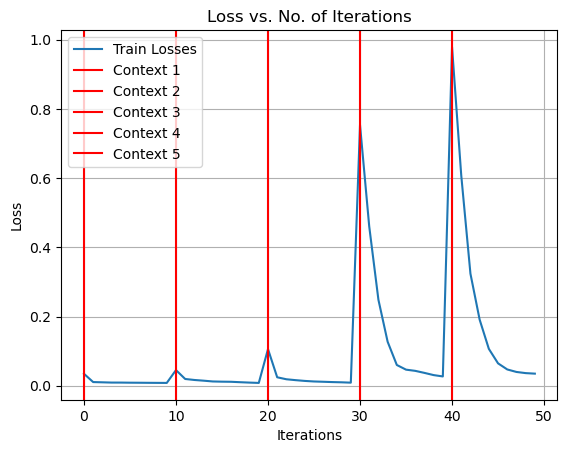

In [42]:
train_losses_flatten = [j for sub in train_losses_per_context for j in sub]

plt.plot(train_losses_flatten, label='Train Losses')
for i in range(1, len(train_contexts) + 1):
    plt.axvline(x=epochs*(i-1), color='r', label=f'Context {i}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of Iterations')

Text(0.5, 1.0, 'Test Loss vs. Contexts')

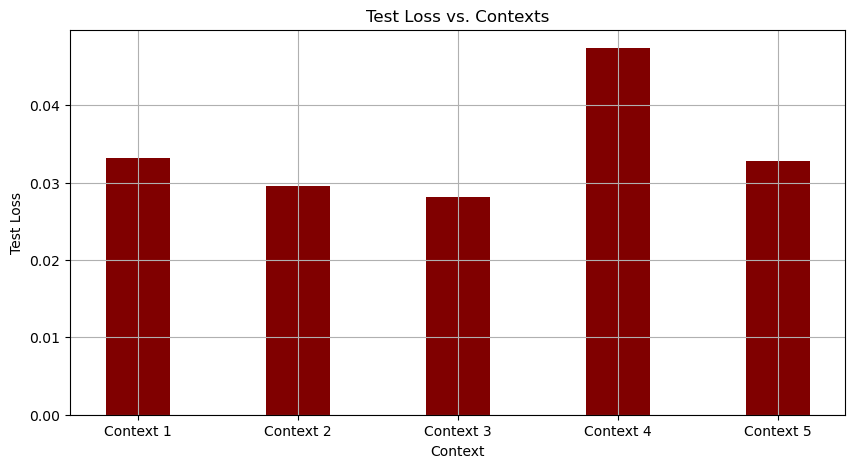

In [43]:
context_list = [f'Context {i+1}' for i in range(len(test_contexts))]

fig = plt.figure(figsize = (10, 5))
plt.bar(context_list, test_losses_per_context, color ='maroon', width = 0.4)
plt.xlabel("Context")
plt.ylabel("Test Loss")
plt.grid(True)
plt.title("Test Loss vs. Contexts")

In [44]:
# Saving model state
state = {
        'model': model.state_dict(),
        'train_losses_per_context': train_losses_per_context,
        'test_losses_per_context': test_losses_per_context,
        'epochs': epochs,
        'lr': lr,
    }

torch.save(state, 'temporal_consistency_regularization_approach.pth')